# Qiskit Aer: Pulse simulation of a backend model

This notebook shows how to use the Aer pulse simulator using a model generated from a backend. In particular, we run a Rabi experiment to find a $\pi$-pulse amplitude on a model of the Armonk one qubit backend, generated from the `FakeArmonk` mock backend.

## Table of contents

1) [Imports](#imports)


2) [Construct model from backend](#model)


3) [Run Rabi experiments and fit $\pi$-pulse amplitude](#rabi)

## 1. Imports <a name='imports'></a>

Import general libraries:

In [1]:
import numpy as np

Import Rabi experiment generator and fitter from Ignis, and other functions for job submission:

In [2]:
from qiskit.ignis.characterization.calibrations import rabi_schedules, RabiFitter

from qiskit.pulse import DriveChannel
from qiskit.compiler import assemble
from qiskit.qobj.utils import MeasLevel, MeasReturnType

Import `PulseSimulator` and `PulseSystemModel` for pulse simulation, as well as the mock Armonk backend:

In [3]:
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel

# Mock Armonk backend
from qiskit.test.mock.backends.armonk.fake_armonk import FakeArmonk

## 2. Construct model from backend <a name='model'></a>

This section demonstrates the use of the `PulseSystemModel.from_backend` function for generating `PulseSystemModel` objects from a backend. 

**Note:** Currently not all system Hamiltonian information is available to the public, missing values have been replaced with $0$. As a result, in this notebook, we need to insert parameters into the backend object by hand. Specifically, we:
- Set the frequency of the qubit.
- Set the value of the drive strength to be consistent with a previously found $\pi$-pulse amplitude found on the actual Armonk device.

Instantiate mock backend:

In [4]:
armonk_backend = FakeArmonk()

Manual insertion of Hamiltonian parameters:

In [5]:
# set the drive strength
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['omegad0'] = 63455017.85

# set the qubit frequency
freq_est = 4.97e9
armonk_backend.defaults().qubit_freq_est = [freq_est]
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['wq0'] = 2*np.pi*freq_est

# test
#setattr(armonk_backend.configuration(), 'meas_levels', [1, 2])

Generate simulator instance from backend:

In [6]:
armonk_sim = PulseSimulator.from_backend(armonk_backend)

In [7]:
armonk_sim.configuration().backend_name

'pulse_simulator(fake_armonk)'

In [8]:
armonk_sim.configuration().description

'A Pulse-based simulator configured from the backend: fake_armonk'

## 3. Run Rabi experiments and fit $\pi$-pulse amplitude <a name='rabi'></a>

Next, we run a Rabi experiments generated using Ignis on the simulator using the system model generated from the Armonk backend.

First, construct Rabi experiment schedules:

In [9]:
# qubit list
qubits = [0]

# drive amplitudes to use
num_exps = 64
drive_amps = np.linspace(0, 1.0, num_exps)

# drive shape parameters
drive_duration = 2048
drive_sigma = 256

# list of drive channels
drive_channels = [DriveChannel(0)]

# construct the schedules
rabi_schedules, xdata = rabi_schedules(amp_list=drive_amps, 
                                       qubits=qubits, 
                                       pulse_width=drive_duration, 
                                       pulse_sigma=drive_sigma,
                                       drives=drive_channels, 
                                       inst_map=armonk_sim.defaults().instruction_schedule_map, 
                                       meas_map=armonk_sim.configuration().meas_map)

/Users/dpuzzuoli/Documents/projects/qiskit-ignis/qiskit/ignis/characterization/calibrations/pulse_schedules.py:82: DeprecationWarning: "measure" has been moved to "qiskit.pulse.macros"
  sched += measure(qubits, inst_map=inst_map, meas_map=meas_map).shift(pulse_width)


Assemble the `qobj` for job submission. When assembling pulse schedules to be used with the pulse simulator, pass the `PulseSimulator` as the backend.

In [10]:
rabi_qobj = assemble(rabi_schedules, 
                     backend=armonk_sim,
                     meas_level=1, 
                     meas_return='avg',
                     shots=512)

Run the simulation:

In [11]:
results = armonk_sim.run(rabi_qobj).result()

Generate the Rabi oscillation plot and find the $\pi$-pulse amplitude:

Pi Amp: 0.348847


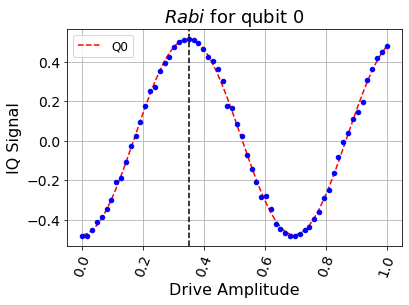

In [12]:
rabi_fit = RabiFitter(results, xdata, qubits, fit_p0 = [1.5, 2, 0, 0])

# get the pi amplitude
pi_amp = rabi_fit.pi_amplitude(0)

# plot
rabi_fit.plot(0)
print('Pi Amp: %f'%pi_amp)

In [13]:
results.get_counts()

[{'0': 1.0},
 {'0': 0.994859701302332, '1': 0.005140298697668},
 {'0': 0.9795446554537, '1': 0.0204553445463},
 {'0': 0.954369492051409, '1': 0.04563050794859},
 {'0': 0.919851957440037, '1': 0.080148042559963},
 {'0': 0.876702325970808, '1': 0.123297674029192},
 {'0': 0.825807299122232, '1': 0.174192700877768},
 {'0': 0.76820922799402, '1': 0.23179077200598},
 {'0': 0.705102496144616, '1': 0.294897503855385},
 {'0': 0.637776505520277, '1': 0.362223494479723},
 {'0': 0.567618434023901, '1': 0.432381565976099},
 {'0': 0.496062817150276, '1': 0.503937182849724},
 {'0': 0.424604692255691, '1': 0.575395307744309},
 {'0': 0.35468332188995, '1': 0.64531667811005},
 {'0': 0.287750132511037, '1': 0.712249867488962},
 {'0': 0.225188123990881, '1': 0.774811876009119},
 {'0': 0.168273359926195, '1': 0.831726640073804},
 {'0': 0.118173523143249, '1': 0.881826476856751},
 {'0': 0.075929008503683, '1': 0.924070991496318},
 {'0': 0.042404530513407, '1': 0.957595469486593},
 {'0': 0.018288700841984, '

In [14]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright